# Transformer Model for Energy Demand in Spain

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/demand_df.csv')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

cities = ['madrid', 'barcelona', 'valencia', 'sevilla', 'bilbao']
# City population density weights
city_weights = {'madrid' : 0.269779,
                'barcelona' : 0.202184,
                'valencia' : 0.200026,
                'sevilla' : 0.186186,
                'bilbao' : 0.141825}

# Create difference between temperature and feelslike feature
for city in cities:
    df[f'feelslike_diff_{city}'] = df[f'temp_{city}'] - df[f'feelslike_{city}']

columns = ['temp', 'feelslike_diff', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth', 'windgust', 'windspeed',
                'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation']

df_final = df[['datetime', 'Actual Total Load (MW)']].copy()

for column in columns:
    df_final[f'weighted_{column}'] = sum(df[f'{column}_{city}'] * weight for city, weight in city_weights.items())
df_final = df_final.round(2)

df_final = df_final.set_index('datetime')

df_final['date'] = df_final.index.date
df_final['hour'] = df_final.index.hour
df_final['day_of_week'] = df_final.index.dayofweek
df_final['month'] = df_final.index.month - 1  # Minus 1 to fit to range 0-11 instead of 1-12
df_final['year'] = df_final.index.year - 2018

# Cyclical encoding of features for hour, day_of_week and month
df_final['hour_sin'] = np.sin(2 * np.pi * df_final['hour'] / 24)
df_final['hour_cos'] = np.cos(2 * np.pi * df_final['hour'] / 24)
df_final['day_of_week_sin'] = np.sin(2 * np.pi * df_final['day_of_week'] / 7)
df_final['day_of_week_cos'] = np.cos(2 * np.pi * df_final['day_of_week'] / 7)
df_final['month_sin'] = np.sin(2 * np.pi * df_final['month'] / 12)
df_final['month_cos'] = np.cos(2 * np.pi * df_final['month'] / 12)

# National Holiday Data
dates_df = pd.read_csv('data/national_holidays.csv', parse_dates=['date'])
dates_list = dates_df['date'].dt.date
df_final['holiday_bool'] = df_final.date.isin(dates_list).astype(int)


df_final['day_shifted_demand'] = np.where(
    df_final['hour'] < 12,
    df_final['Actual Total Load (MW)'].shift(24),  # Use 24-hour shift if hour < 12
    df_final['Actual Total Load (MW)'].shift(48)   # Use 48-hour shift if hour >= 12
)

df_final['week_shifted_demand'] = df_final['Actual Total Load (MW)'].shift(168)

df_final.drop(['date', 'hour', 'day_of_week', 'month'], axis=1, inplace=True)
df_final = df_final[168:-1]

print(df_final.columns)


Index(['Actual Total Load (MW)', 'weighted_temp', 'weighted_feelslike_diff',
       'weighted_dew', 'weighted_humidity', 'weighted_precip',
       'weighted_precipprob', 'weighted_snow', 'weighted_snowdepth',
       'weighted_windgust', 'weighted_windspeed', 'weighted_winddir',
       'weighted_sealevelpressure', 'weighted_cloudcover',
       'weighted_visibility', 'weighted_solarradiation', 'year', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'holiday_bool', 'day_shifted_demand',
       'week_shifted_demand'],
      dtype='object')


In [3]:
num_days = len(df_final) // 24
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_numerical = df_final.drop(columns=['Actual Total Load (MW)'])
X_numerical_normal = scaler_X.fit_transform(X_numerical)
X_numerical_norm = np.lib.stride_tricks.sliding_window_view(X_numerical_normal, window_shape=(24, X_numerical.shape[1])).squeeze(axis=1)
print(X_numerical_norm.shape)

y = df_final['Actual Total Load (MW)'].values.reshape(-1, 1)
y_normal = scaler_y.fit_transform(y)
y_norm = np.lib.stride_tricks.sliding_window_view(y_normal, window_shape=(24, 1)).squeeze(axis=1).squeeze(axis=2)
print(y_norm.shape)

indices_to_remove = np.arange(0, X_numerical_norm.shape[0], 24)
X_numerical_norm_no_12 = np.delete(X_numerical_norm, indices_to_remove, axis=0)
y_norm_no_12 = np.delete(y_norm, indices_to_remove, axis=0)
print(y_norm_no_12.shape)


X_numerical_norm_12 = X_numerical_normal.reshape(num_days, 24, -1)
y_norm_12 = y_normal.reshape(num_days, 24)
print(y_norm_12.shape)

(43657, 24, 25)
(43657, 24)
(41837, 24)
(1820, 24)


In [4]:
# Take the last 20% of samples as the test set
X_num_test_12 = X_numerical_norm_12[1456:]
y_test_12 = y_norm_12[1456:]

# Use the rest as the training set
X_num_train_12 = X_numerical_norm_12[:1456]
y_train_12 = y_norm_12[:1456]

# Do the same for the other dataset
X_num_test = X_numerical_norm_no_12[33468:]
y_test = y_norm_no_12[33468:]

X_num_train_temp = X_numerical_norm_no_12[:33468]
y_train_temp = y_norm_no_12[:33468]

X_num_train = np.append(X_num_train_temp, X_num_train_12, axis=0)
y_train = np.append(y_train_temp, y_train_12, axis=0)

# Convert to PyTorch tensors
X_num_train = torch.tensor(X_num_train, dtype=torch.float32)
X_num_train_12 = torch.tensor(X_num_train_12, dtype=torch.float32)
X_num_test = torch.tensor(X_num_test, dtype=torch.float32)
X_num_test_12 = torch.tensor(X_num_test_12, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train_12 = torch.tensor(y_train_12, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test_12 = torch.tensor(y_test_12, dtype=torch.float32)

In [5]:
class EnergyDemandForecast(nn.Module):
    def __init__(self, num_features, d_model=64, dim_feedforward=256, nhead=4, num_layers=4, target_length=24, dropout=0.4):
        super(EnergyDemandForecast, self).__init__()

        # --- Learnable Positional Encoding ---
        self.pos_embedding = nn.Parameter(torch.randn(1, target_length, d_model))

        self.feature_projection = nn.Linear(num_features, d_model)  # Include categorical embeddings

        # --- Transformer Encoder ---
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # --- Final Output Layer ---
        self.fc = nn.Linear(d_model, 1)  # Predicts a single value per timestep

    def forward(self, numerical_features):
        """
        Inputs:
        - numerical_features: (batch_size, 24, num_features) -> Past and future features for each timestep
        """

        features = self.feature_projection(numerical_features)  # (batch_size, 24, d_model)

        # --- Add Positional Encoding ---
        features += self.pos_embedding  # (batch_size, 24, d_model)

        # --- Transformer Encoder ---
        encoded_features = self.encoder(features)  # (batch_size, 24, d_model)

        # --- Predict Energy Demand ---
        output = self.fc(encoded_features).squeeze(-1)  # (batch_size, 24)

        return output

In [6]:
# Create TensorDatasets
train_dataset = TensorDataset(X_num_train, y_train)
test_dataset = TensorDataset(X_num_test, y_test)
train_12_dataset = TensorDataset(X_num_train_12, y_train_12)
test_12_dataset = TensorDataset(X_num_test_12, y_test_12)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_12_loader = DataLoader(train_12_dataset, batch_size=32, shuffle=True)
test_12_loader = DataLoader(test_12_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnergyDemandForecast(num_features=25).to(device)
loss_function = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98))


In [7]:
# Training loop
num_epochs = 20
patience = 7  # Number of epochs with no improvement to wait before stopping
best_val_loss = np.inf
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    total_loss = 0

    # Training phase
    for batch in train_loader:
        num_feat, y = [b.to(device) for b in batch]  # Move batch to device

        optimizer.zero_grad()  # Reset gradients
        predictions = model(num_feat)  # Forward pass
        loss = loss_function(predictions, y)  # Compute loss
        loss.backward()
        optimizer.step()  # Update weights
        total_loss += loss.mean().item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():  # No gradient tracking during validation
        for batch in test_loader:
            num_feat, y = [b.to(device) for b in batch]  # Move batch to device

            predictions = model(num_feat)  # Forward pass
            loss = loss_function(predictions, y)  # Compute loss
            loss_mean = loss.mean()
            val_loss += loss_mean.item()

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, "
        f"Training Loss: {total_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss / len(test_loader):.4f}")

    # Early stopping: Check if the validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update best validation loss
        epochs_without_improvement = 0  # Reset counter if improvement
    else:
        epochs_without_improvement += 1  # Increment counter for no improvement

    # Stop training if validation loss hasn't improved for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
        break

print("Training complete!")

Epoch 1/20, Training Loss: 0.1277, Validation Loss: 0.0832
Epoch 2/20, Training Loss: 0.0514, Validation Loss: 0.0561
Epoch 3/20, Training Loss: 0.0372, Validation Loss: 0.0487
Epoch 4/20, Training Loss: 0.0300, Validation Loss: 0.0513
Epoch 5/20, Training Loss: 0.0250, Validation Loss: 0.0575
Epoch 6/20, Training Loss: 0.0219, Validation Loss: 0.0408
Epoch 7/20, Training Loss: 0.0195, Validation Loss: 0.0518
Epoch 8/20, Training Loss: 0.0177, Validation Loss: 0.0383
Epoch 9/20, Training Loss: 0.0163, Validation Loss: 0.0395
Epoch 10/20, Training Loss: 0.0150, Validation Loss: 0.0525
Epoch 11/20, Training Loss: 0.0139, Validation Loss: 0.0487
Epoch 12/20, Training Loss: 0.0131, Validation Loss: 0.0405
Epoch 13/20, Training Loss: 0.0123, Validation Loss: 0.0545
Epoch 14/20, Training Loss: 0.0118, Validation Loss: 0.0370
Epoch 15/20, Training Loss: 0.0112, Validation Loss: 0.0553
Epoch 16/20, Training Loss: 0.0107, Validation Loss: 0.0558
Epoch 17/20, Training Loss: 0.0104, Validation Lo

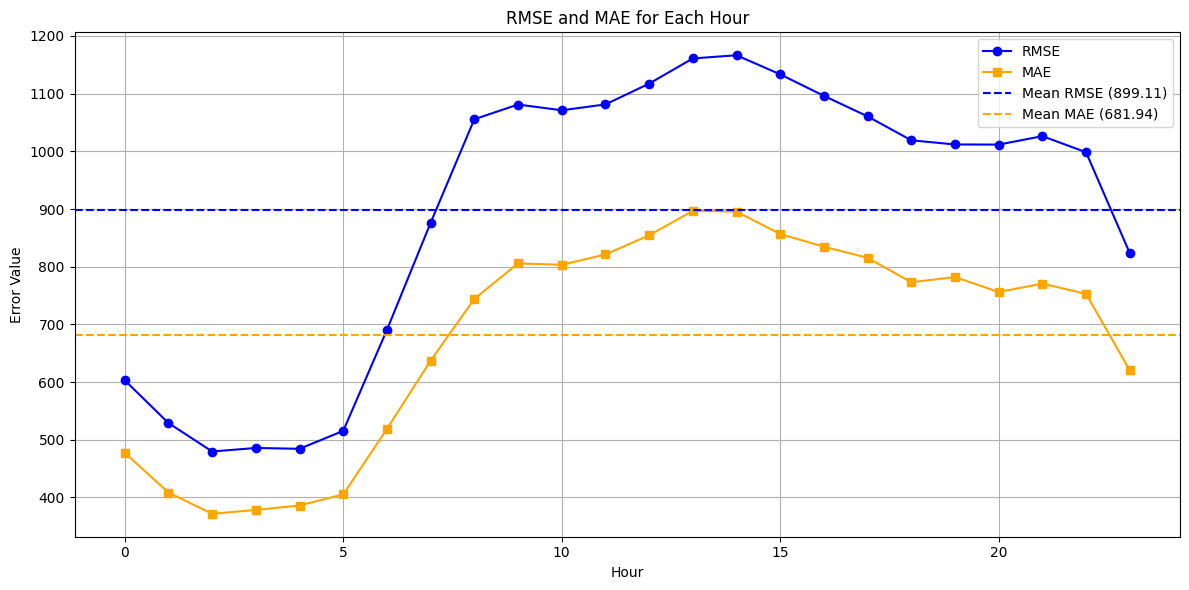

MAPE: 2.57%


In [8]:
# Initialize lists for storing actual and predicted values
all_predictions = []
all_actuals = []

# Iterate over test DataLoader (if using DataLoader, otherwise use test tensors directly)
model.eval()
for batch in test_12_loader:
    num_feat, y_actual = [b.to(device) for b in batch]  # Move to device (CPU/GPU)

    with torch.no_grad():  # No gradient tracking
        y_pred = model(num_feat)  # Get predictions

    all_predictions.append(y_pred.cpu().numpy())  # Store predictions
    all_actuals.append(y_actual.cpu().numpy())  # Store actual values

# Convert lists to numpy arrays
all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: (num_test_samples, 24)
all_actuals = np.concatenate(all_actuals, axis=0)  # Shape: (num_test_samples, 24)

all_predictions_original = scaler_y.inverse_transform(all_predictions)  # Convert back to real MW values
all_actuals_original = scaler_y.inverse_transform(all_actuals)

mae = mean_absolute_error(all_actuals_original, all_predictions_original, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(all_actuals_original, all_predictions_original, multioutput='raw_values'))
mean_rmse = np.mean(rmse)
mean_mae = np.mean(mae)
mape = np.mean(np.abs((all_actuals_original - all_predictions_original) / all_actuals_original)) * 100

plt.figure(figsize=(12, 6))
plt.plot(rmse, label='RMSE', marker='o', linestyle='-', color='blue')
plt.plot(mae, label='MAE', marker='s', linestyle='-', color='orange')
plt.axhline(mean_rmse, color='blue', linestyle='--', label=f'Mean RMSE ({mean_rmse:.2f})')
plt.axhline(mean_mae, color='orange', linestyle='--', label=f'Mean MAE ({mean_mae:.2f})')

plt.title('RMSE and MAE for Each Hour')
plt.xlabel('Hour')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"MAPE: {mape:.2f}%")

In [9]:
# Save the trained model
torch.save(model.state_dict(), "models/transformer_model_state.pth")